In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier

In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
df = pd.read_csv("../data/raw/processed.cleveland.data", names=columns)

In [4]:
df.replace("?", np.nan, inplace=True)
df = df.astype(float)
df.fillna(df.median(), inplace=True)

In [6]:
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (303, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0     0.0  
1    2.0  3.0   3.0     2.0  
2    2.0  2.0   7.0     1.0  
3    3.0  0.0   3.0     0.0  
4    1.0  0.0   3.0     0.0  


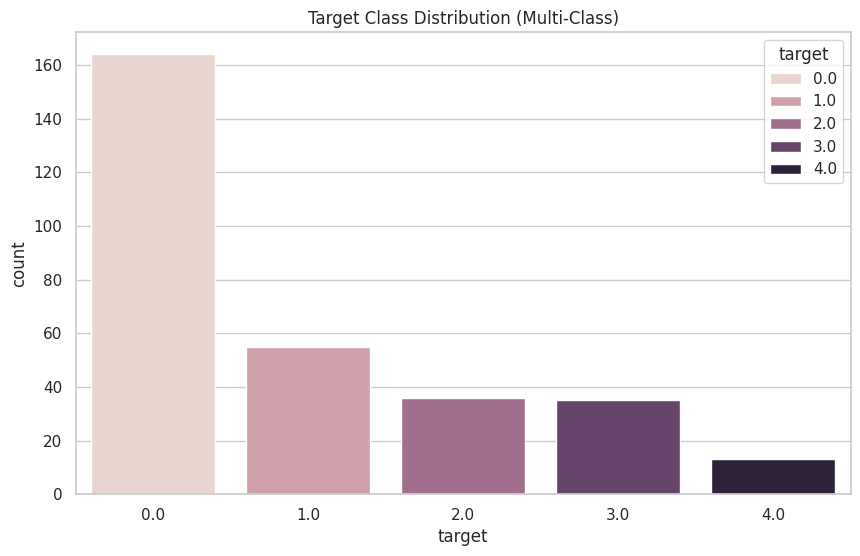

In [11]:
sns.countplot(data=df, x="target", hue="target")
plt.title("Target Class Distribution (Multi-Class)")
plt.show()

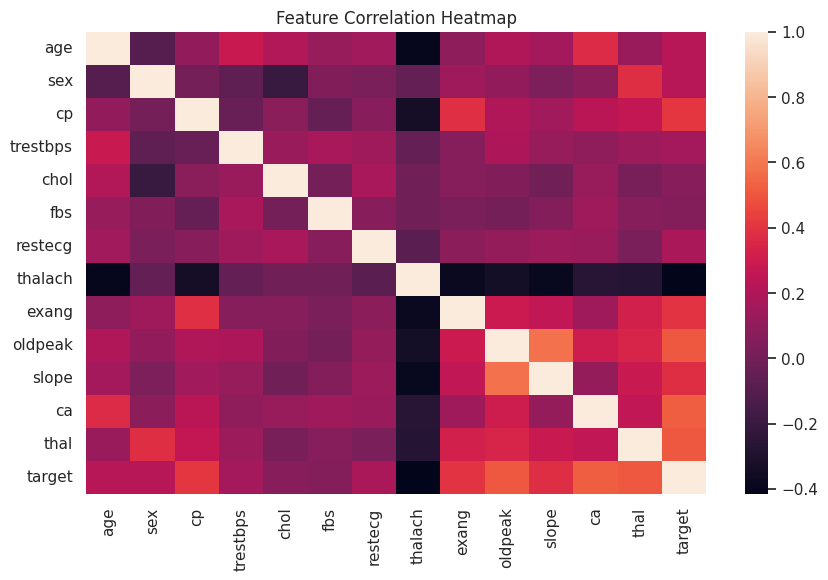

In [12]:
sns.heatmap(df.corr())
plt.title("Feature Correlation Heatmap")
plt.show()

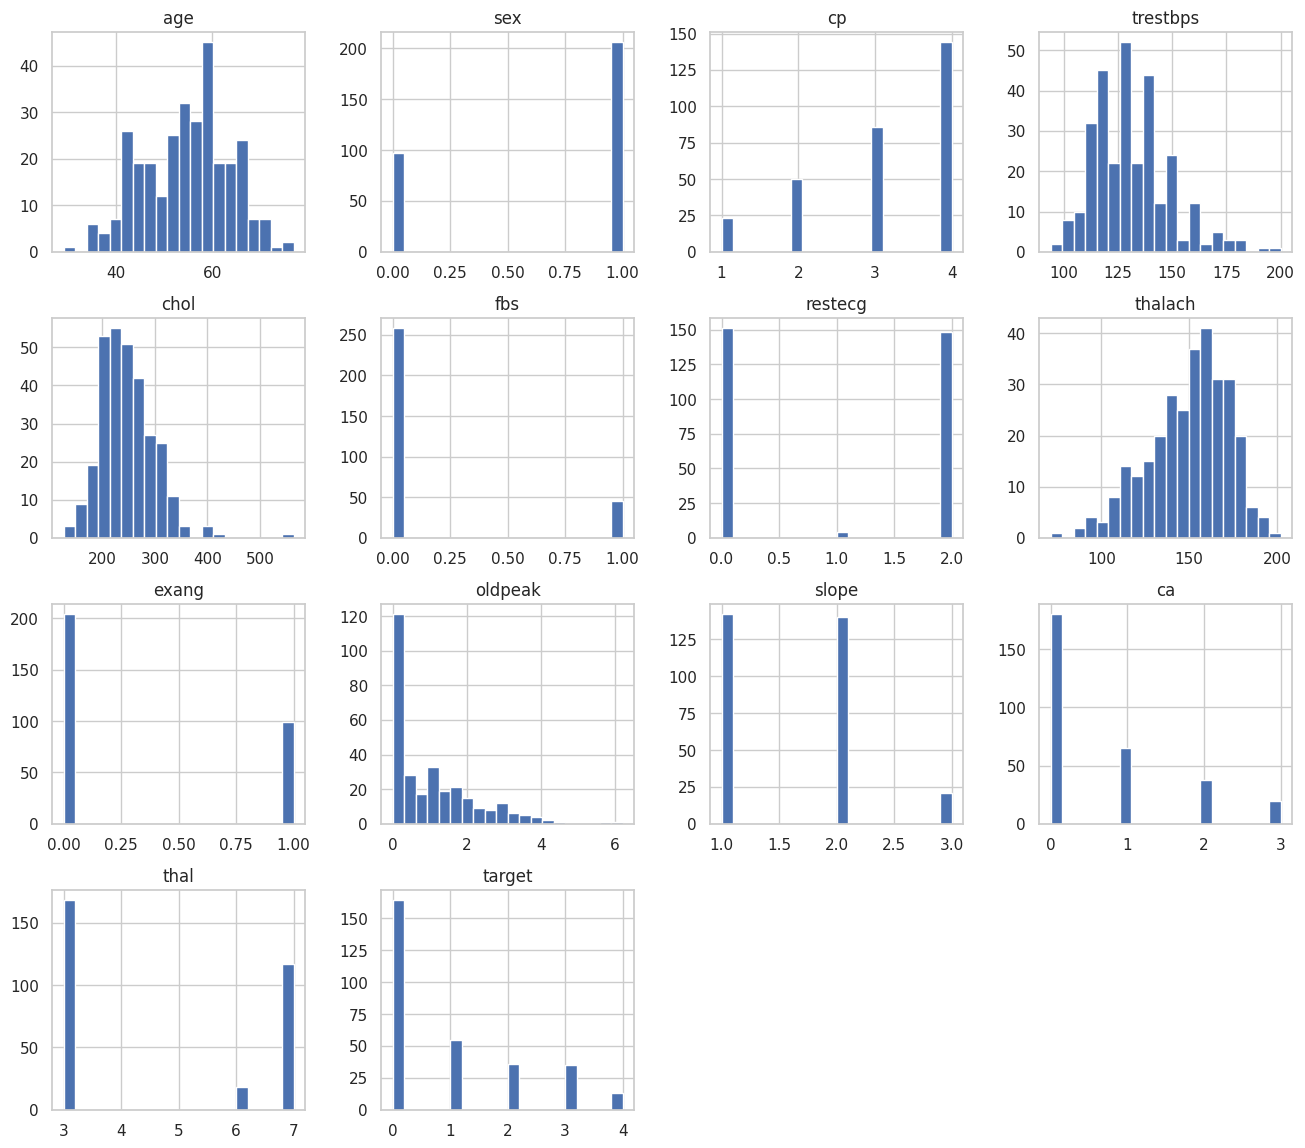

In [18]:
df.hist(bins=20, figsize=(16, 14))
plt.title("Feature Distributiosn")
plt.show()

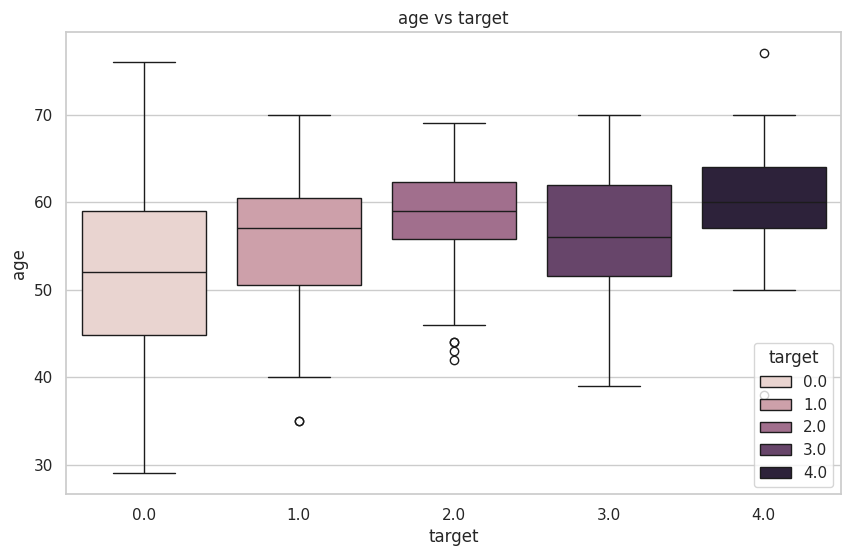

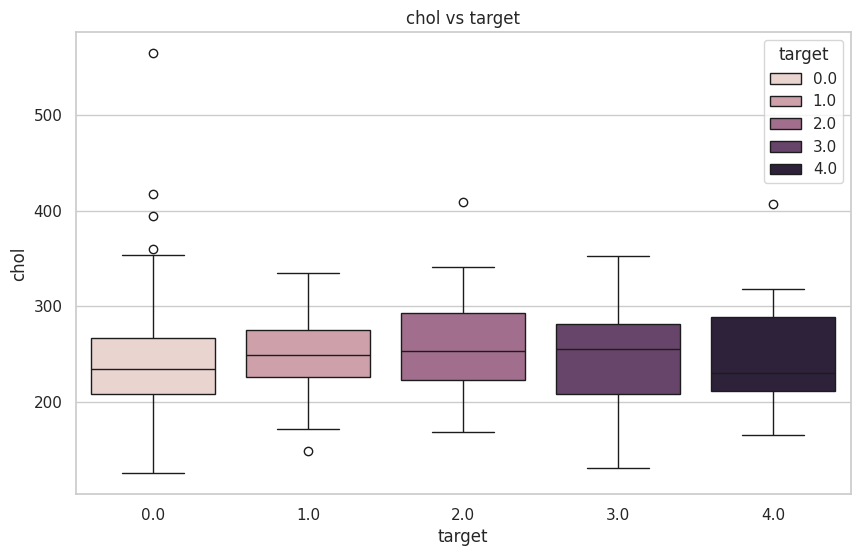

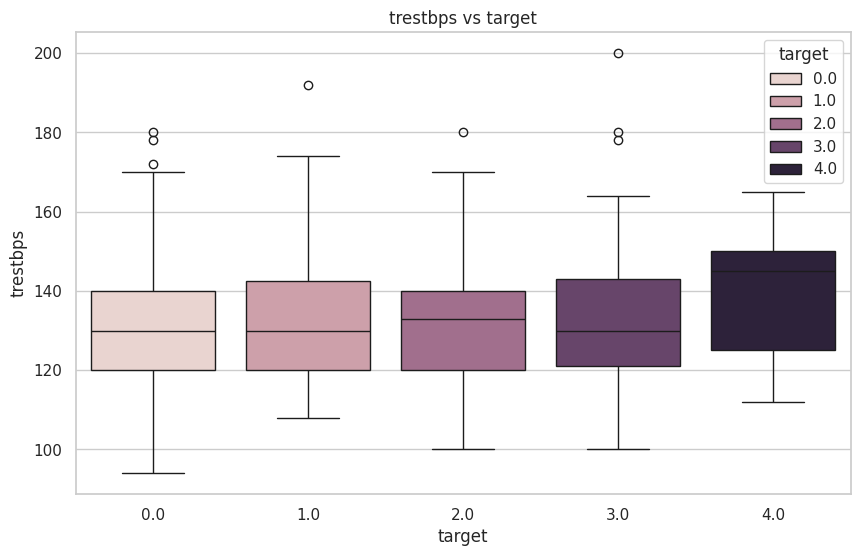

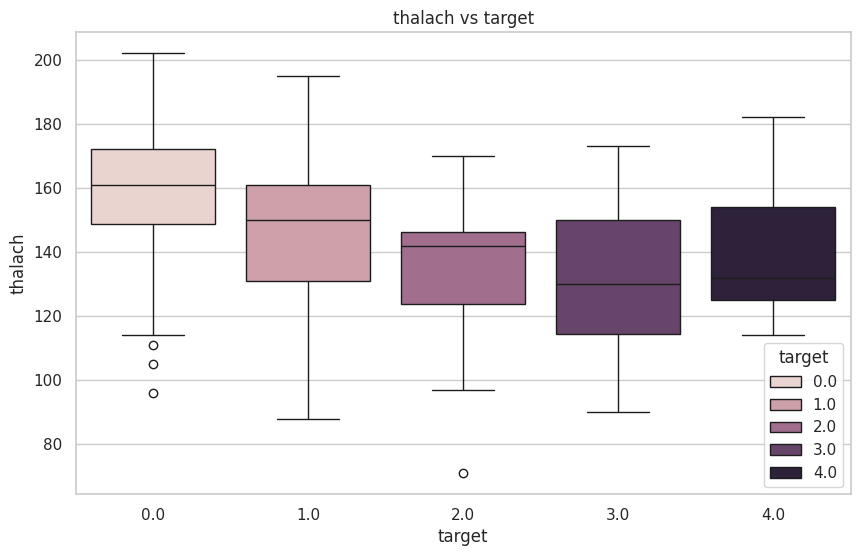

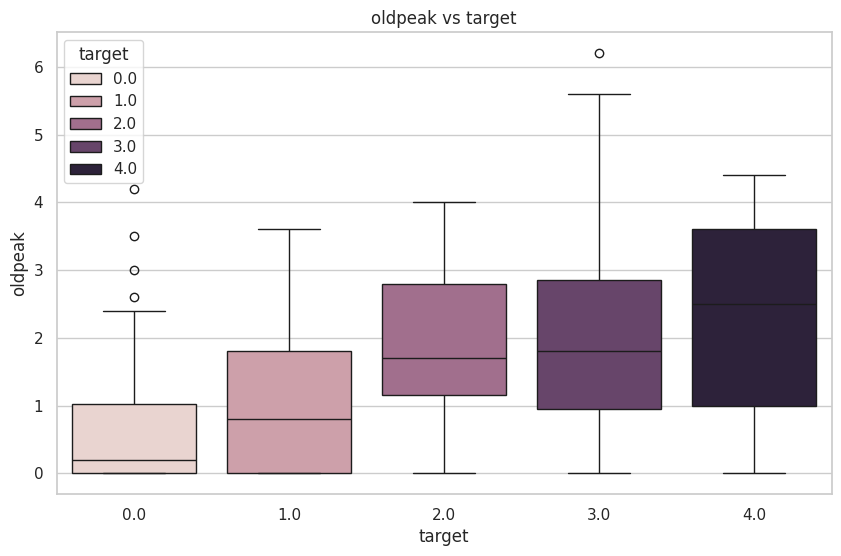

In [20]:
for col in ['age', 'chol', 'trestbps', 'thalach', 'oldpeak']:
    sns.boxplot(x='target', y=col, data=df, hue='target')
    plt.title(f"{col} vs target")
    plt.show()

In [21]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

In [23]:
model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    learning_rate=0.05,
    max_depth=4,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

eval_set = [(X_train, y_train), (X_val, y_val)]

In [24]:
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.42538	validation_1-mlogloss:1.44226
[1]	validation_0-mlogloss:1.38202	validation_1-mlogloss:1.41402
[2]	validation_0-mlogloss:1.33966	validation_1-mlogloss:1.38860
[3]	validation_0-mlogloss:1.29871	validation_1-mlogloss:1.36822
[4]	validation_0-mlogloss:1.26355	validation_1-mlogloss:1.34834
[5]	validation_0-mlogloss:1.22867	validation_1-mlogloss:1.32786
[6]	validation_0-mlogloss:1.19795	validation_1-mlogloss:1.30576
[7]	validation_0-mlogloss:1.16826	validation_1-mlogloss:1.29070
[8]	validation_0-mlogloss:1.13698	validation_1-mlogloss:1.27577
[9]	validation_0-mlogloss:1.10906	validation_1-mlogloss:1.25993
[10]	validation_0-mlogloss:1.08007	validation_1-mlogloss:1.24679
[11]	validation_0-mlogloss:1.05258	validation_1-mlogloss:1.23237
[12]	validation_0-mlogloss:1.02904	validation_1-mlogloss:1.21991
[13]	validation_0-mlogloss:1.00636	validation_1-mlogloss:1.20585
[14]	validation_0-mlogloss:0.98405	validation_1-mlogloss:1.19455
[15]	validation_0-mlogloss:0.96218	

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [26]:
results = model.evals_result()

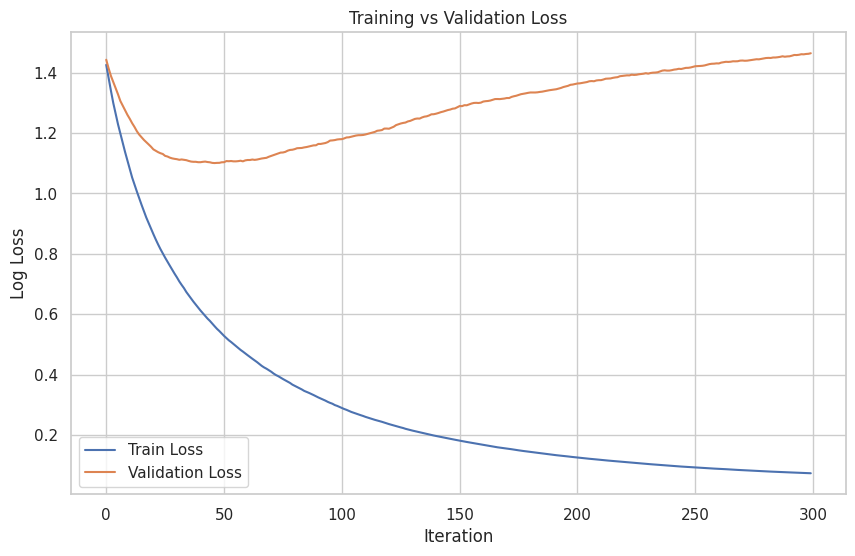

In [27]:
plt.plot(results["validation_0"]["mlogloss"], label="Train Loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [28]:
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

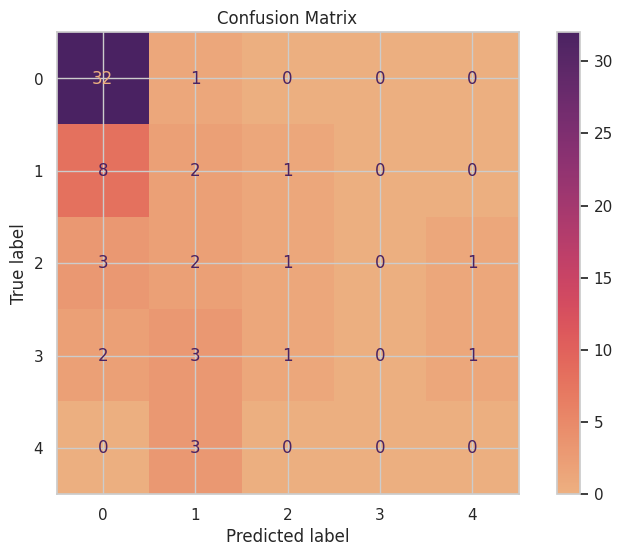

In [44]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="flare")
plt.title("Confusion Matrix")
plt.show()

In [46]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_val, y_pred, average="weighted")
f1 = f1_score(y_val, y_pred, average="weighted")
roc_auc = roc_auc_score(y_val, y_proba, multi_class="ovr")

print(
f"""
Accuracy:  {accuracy:.4f}
Precision: {precision:.4f}
Recall:    {recall:.4f}
F1-Score:  {f1:.4f}
ROC-AUC:   {roc_auc:.4f}
"""
)


Accuracy:  0.5738
Precision: 0.4557
Recall:    0.5738
F1-Score:  0.4996
ROC-AUC:   0.7773



In [48]:
print(classification_report(y_val, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.71      0.97      0.82        33
         1.0       0.18      0.18      0.18        11
         2.0       0.33      0.14      0.20         7
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.57        61
   macro avg       0.25      0.26      0.24        61
weighted avg       0.46      0.57      0.50        61



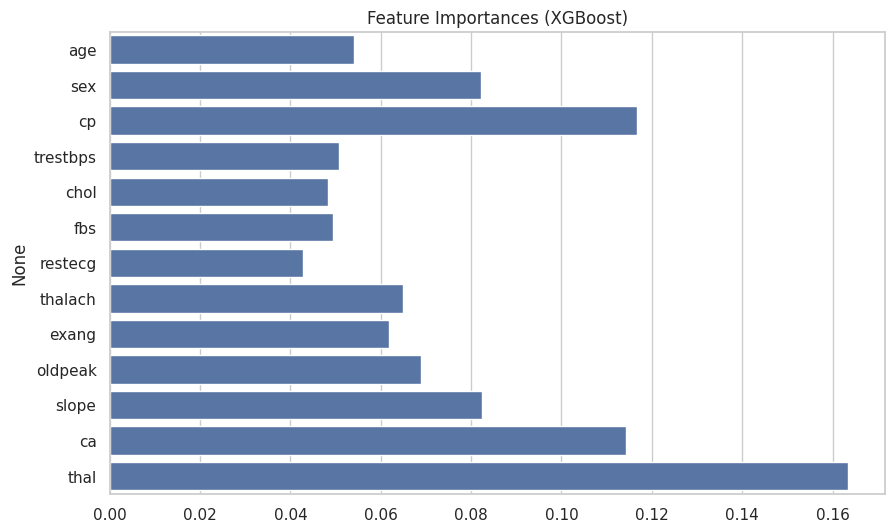

In [52]:
importances = model.feature_importances_
features = df.drop("target", axis=1).columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importances (XGBoost)")
plt.show()

In [71]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(
f"""
Accuracy:  {accuracy_score(y_test, y_pred):.4f}
Precision: {precision_score(y_test, y_pred, average="weighted", zero_division=0):.4f}
Recall:    {recall_score(y_test, y_pred, average="weighted"):.4f}
F1-Score:  {f1_score(y_test, y_pred, average="weighted"):.4f}
{f"ROC-AUC:   {roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")}" if hasattr(model, "predict_proba") else ""}
"""
    )
    print(classification_report(y_test, y_pred, zero_division=0))

    if hasattr(model, "predict_proba"):
        classes = np.unique(y_test)
        y_val_bin = label_binarize(y_test, classes=classes)
        y_proba = model.predict_proba(X_test)
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class: {cls} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [1, 0], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi Class ROC Curves (One vs Rest)")
    plt.legend()
    plt.show()

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [73]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=30),
    "Random Forest": RandomForestClassifier(n_estimators=128),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(objective="multi:softprob", num_class=5)
}

In [74]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

=== LogisticRegression ==

Accuracy:  0.5902
Precision: 0.5464
Recall:    0.5902
F1-Score:  0.5666
ROC-AUC:   0.7958226932709691

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83        33
         1.0       0.30      0.27      0.29        11
         2.0       0.17      0.14      0.15         7
         3.0       0.43      0.43      0.43         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.59        61
   macro avg       0.34      0.34      0.34        61
weighted avg       0.55      0.59      0.57        61



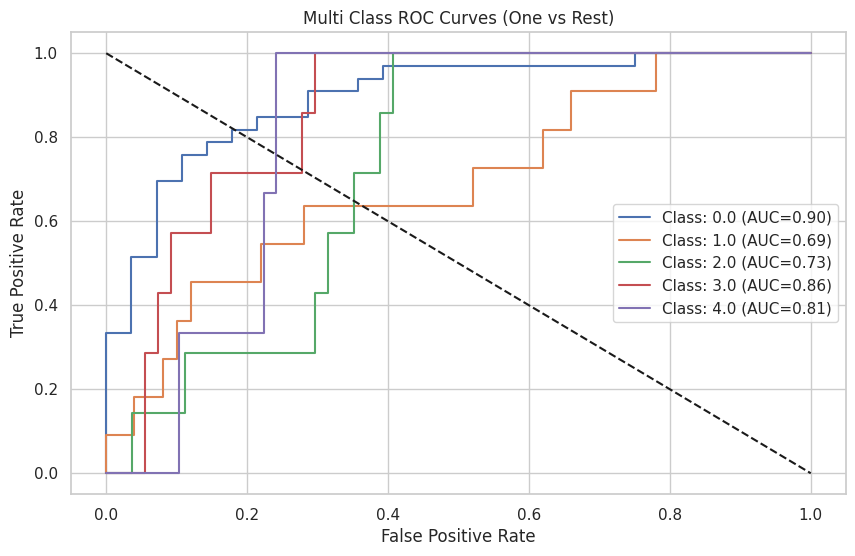

===== Random Forest =====

Accuracy:  0.5246
Precision: 0.4222
Recall:    0.5246
F1-Score:  0.4679
ROC-AUC:   0.7695007546731685

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86        33
         1.0       0.00      0.00      0.00        11
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.52        61
   macro avg       0.16      0.19      0.17        61
weighted avg       0.42      0.52      0.47        61



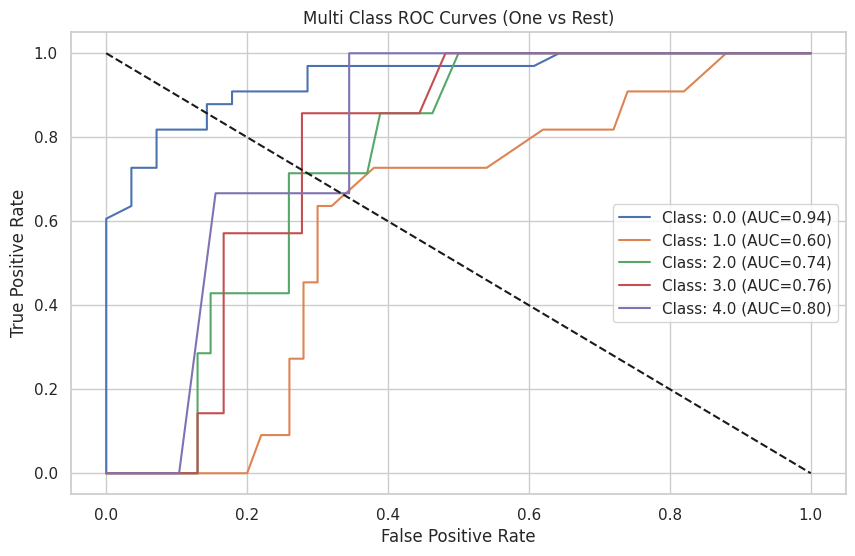

========== SVM ==========

Accuracy:  0.5410
Precision: 0.4261
Recall:    0.5410
F1-Score:  0.4757
ROC-AUC:   0.7948780083262842

              precision    recall  f1-score   support

         0.0       0.72      0.94      0.82        33
         1.0       0.20      0.18      0.19        11
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.54        61
   macro avg       0.18      0.22      0.20        61
weighted avg       0.43      0.54      0.48        61



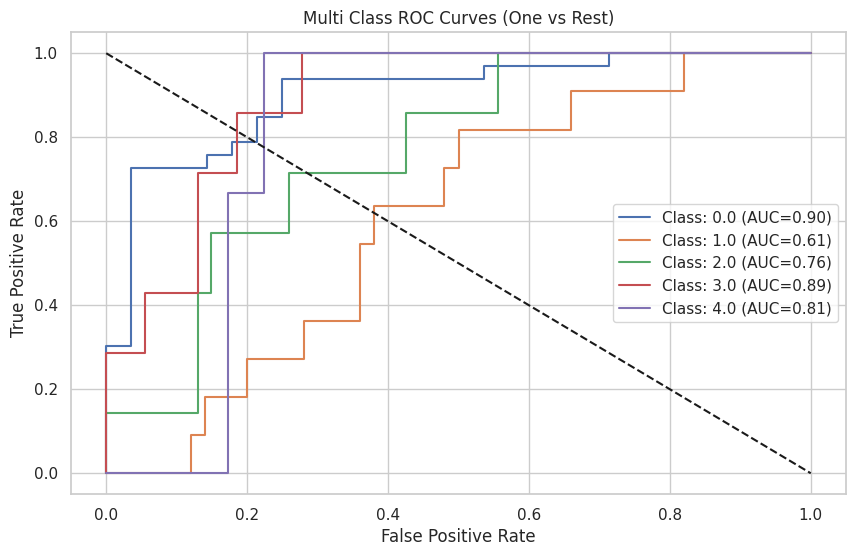

======== XGBoost ========

Accuracy:  0.5902
Precision: 0.4529
Recall:    0.5902
F1-Score:  0.5072
ROC-AUC:   0.7805784611301851

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84        33
         1.0       0.20      0.18      0.19        11
         2.0       0.25      0.14      0.18         7
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.59        61
   macro avg       0.23      0.26      0.24        61
weighted avg       0.45      0.59      0.51        61



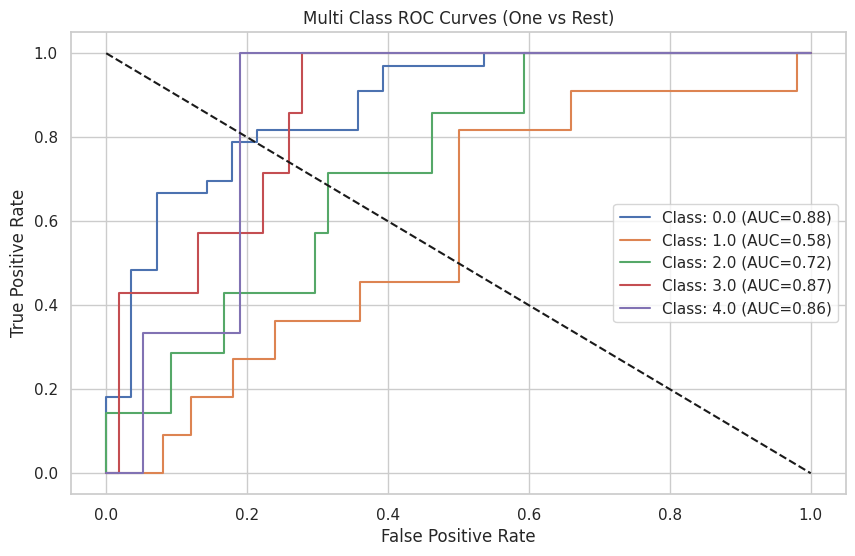

In [75]:
for name, model in models.items():
    print(f" {name} ".center(25, "="))
    model.fit(X_train, y_train)
    evaluate_model(model, X_val, y_val)